In [84]:
import pandas as pd 
from pathlib import Path
import sys

# Import scientific librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Add project directory to kernel paths
sys.path.append('../../')

print("We're running localy")

We're running localy


In [85]:
from src.data.file_manager import FileManager
weatherManager = FileManager()
color_pal = sns.color_palette()

In [86]:
raw_dir_path = weatherManager.data_dir / 'raw'

raw_path = str(raw_dir_path / 'full_data.csv')
df_final = pd.read_csv(raw_path)
# df_final.set_index("Years" , inplace=True)

#on rename index par Year
df_final = df_final.rename(columns={'Years': 'ds'})
df_final = df_final.rename(columns={'AverageTemperature': 'y'})
df_final

,ds,y
0,2000-01-01,11.738083
1,2001-01-01,11.361583
2,2002-01-01,11.767500
3,2003-01-01,12.076917
4,2004-01-01,11.266333
5,2005-01-01,11.229083
6,2006-01-01,11.871250
7,2007-01-01,11.571833
8,2008-01-01,11.200750
9,2009-01-01,11.607500


In [87]:
# Convert the column to the datetime format
df_final['ds'] = pd.to_datetime(df_final['ds'])

# Split the data into train and test based on the date
train = df_final.loc[df_final['ds'] < '2015-01-01']
test = df_final.loc[df_final['ds'] >= '2015-01-01']

In [88]:
m = Prophet(        
    seasonality_mode='multiplicative',
    yearly_seasonality=False,
    seasonality_prior_scale=1,
)
m.add_seasonality(name='non-seasonal', period=1, fourier_order=12, mode='additive')
# Fit the model to the training data
m_train = m.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [89]:
future = m_train.make_future_dataframe(periods=10, freq='Y')
future

,ds
0,2000-01-01
1,2001-01-01
2,2002-01-01
3,2003-01-01
4,2004-01-01
5,2005-01-01
6,2006-01-01
7,2007-01-01
8,2008-01-01
9,2009-01-01


In [90]:
# Python
forecast = m_train.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2000-01-01,11.303307,10.450828,12.171359
1,2001-01-01,11.365050,10.517423,12.159357
2,2002-01-01,11.426625,10.567564,12.252620
3,2003-01-01,11.488200,10.660097,12.335314
4,2004-01-01,11.549775,10.653343,12.335053
5,2005-01-01,11.611518,10.789045,12.447156
6,2006-01-01,11.673093,10.865619,12.503107
7,2007-01-01,11.734686,10.852500,12.580656
8,2008-01-01,11.796284,11.008619,12.721003
9,2009-01-01,11.858060,10.958428,12.666928


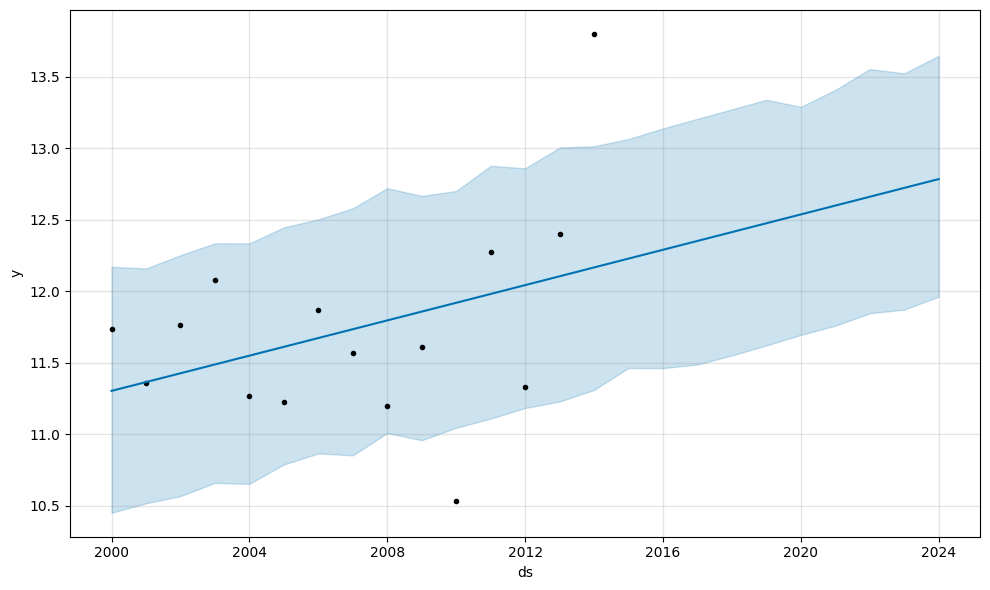

In [91]:
# Python
fig1 = m.plot(forecast)

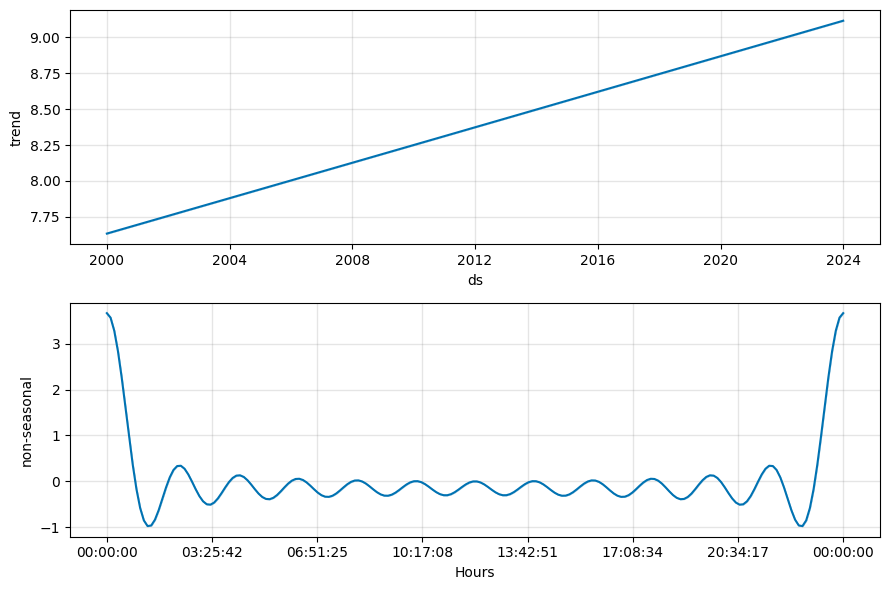

In [92]:
# Python
fig2 = m.plot_components(forecast)

Adding Holiday

Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to the training.

We will use the built in pandas USFederalHolidayCalendar to pull a list of holidays.

Predict on training set with model